<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
- [ ] Compute trajectory in 3D (Up to scale)
- [ ] Compare trajectory with ground truth data. (Whthout bundle adjustment)
- [ ] Pose-Graph Optimization

# pip3 install

In [1]:
!pip3 install scikit-image

# import

In [2]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# Load kitti dataset

In [3]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")
timestamps_file_path = os.path.join(dataset_dir, "timestamps.txt")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

--2022-01-03 03:54:06--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.79
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367093728 (350M) [application/zip]
Saving to: ‘2011_09_26_drive_0020_sync.zip’

2011_09_26_drive_00 100%[===================>] 350.09M  64.8MB/s    in 5.4s    

2022-01-03 03:54:12 (65.0 MB/s) - ‘2011_09_26_drive_0020_sync.zip’ saved [367093728/367093728]



In [4]:
kitti_cam_calib = np.array([[7.215377e+02,0.000000e+00,6.095593e+02],
                            [0.000000e+00,7.215377e+02,1.728540e+02],
                            [0.000000e+00,0.000000e+00,1.000000e+00]])

# Load deer_robot dataset

In [95]:
if "deer_robot.zip" not in os.listdir():
  !wget https://www.doc.ic.ac.uk/~wl208/lmdata/deer_robot.zip
  !unzip  deer_robot.zip >/dev/null

imgs_dir = "./deer_robot/cam0/data"
metadata_file = "./deer_robot/cam0/data.csv"
poses_gt_file = "./deer_robot/poses.gt"

def load_metadata():
  with open(metadata_file, 'r') as fd:
      metadata = fd.readlines()

  imgs_file = [
      line.split(',')[1][:-1] for line in metadata[1:]
  ]
  imgs_path = [os.path.join(imgs_dir, f) for f in imgs_file]
  timestamps = [float(line.split(',')[0])/1e9 for line in metadata[1:]]
  return imgs_path, timestamps

def load_poses_gt():
  with open(poses_gt_file, 'r') as fd:
    positions = []
    orientations = []
    for line in fd:
      if line[0] == '#':
        continue

      split = line.split(',')
      px = float(split[1])
      py = float(split[2])
      pz = float(split[3])
      p = [px, py, pz]
      positions.append(p)

      qw = float(split[4])
      qx = float(split[5])
      qy = float(split[6])
      qz = float(split[7])
      q = [qx, qy, qz, qw]
      orientations.append(q)
  return np.array(positions), np.array(orientations)

def load_batch(start, size):
  imgs_path, timestamps = load_metadata()
  imgs = np.array([
      cv2.imread(img_path) for img_path in imgs_path[start:start+size]
  ])
  p, q = load_poses_gt()
  return imgs, timestamps[start:start+size], p[start:start+size], q[start:start+size]

deer_robot_imgs, deer_robot_timestamps, deer_robot_p, deer_robot_q = load_batch(0, 100)

In [96]:
deer_robot_cam_calib = np.array([
  [600, 0, 320],
  [0, 600, 240],
  [0,   0,   1]
], dtype=np.float)

# Disp utils

In [91]:
def disp(img_tn1, kps_tn1, kps_t):
  disp_img = img_tn1.copy()
  for kp_tn1, kp_t in zip(kps_tn1, kps_t):
    start_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 1, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, end_point, (0, 255, 0), 1)
  cv2_imshow(disp_img)

def disp2(img_tn2, kps_tn2, kps_tn1, kps_t):
  disp_img = img_tn2.copy()
  for kp_tn2, kp_tn1, kp_t in zip(kps_tn2, kps_tn1, kps_t):
    start_point = tuple(kp_tn2)
    middle_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 1, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, middle_point, (0, 255, 0), 1)
    disp_img = cv2.line(disp_img, middle_point, end_point, (255, 0, 0), 1)
  cv2_imshow(disp_img)

# Essential matrix utils

In [6]:
def triangulate(x_tn1, x_t, R, t):
  """
  Args:
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_tn1 of point to triangulate.
    x_t: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_t of point to triangulate.
    R: numpy array of shape (3,3) representing rotation of camera frame
      at time t wrt camera frame at time tn1.
    t: numpy array of shape (3,) representing baseline vector between 
    camera frame at time t and camera frame at time tn1.
  """
  A = np.array([
    [np.dot(x_tn1, x_tn1), -np.dot(R @ x_t, x_tn1)],
    [np.dot(x_tn1, R @ x_t), -np.dot(R @ x_t, R @ x_t)]
  ])
  b = np.array([np.dot(t, x_tn1) ,np.dot(t, R @ x_t)])
  alpha, beta = np.linalg.inv(A) @ b
  p_tn1 = alpha * x_tn1
  p_t = t + (beta * (R @ x_t))
  return (p_tn1 + p_t)/2

def essential_to_Rt(E, x_tn1, x_t):
  """
  Args:
    E: numpy array of shape (3,3) representing Essential matrix.
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_tn1.
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_t corresponding to x_tn1.
  """
  u,s,vt = np.linalg.svd(E)
  w = np.array([[0,-1,0],
                [1,0,0],
                [0,0,1]])
  R1 = u @ w.T @ vt
  if np.linalg.det(R1) < 0:
    R1 = -R1
  R2 = u @ w @ vt
  if np.linalg.det(R2) < 0:
    R2 = -R2

  t1 = u @ w @ np.diag(s) @ u.T
  t1 = np.array([t1[2,1], t1[0,2], t1[1,0]])
  t1 = t1/np.linalg.norm(t1)
  t2 = -t1

  # Resolve ambiguities by triangulation
  p11_tn1 = triangulate(x_tn1, x_t, R1, t1)
  p11_t = R1.T @ (p11_tn1 - t1)
  if p11_tn1[2] > 0 and p11_t[2] > 0:
    return R1, t1

  p12_tn1 = triangulate(x_tn1, x_t, R1, t2)
  p12_t = R1.T @ (p12_tn1 - t2)
  if p12_tn1[2] > 0 and p12_t[2] > 0:
    return R1, t2
  
  p21_tn1 = triangulate(x_tn1, x_t, R2, t1)
  p21_t = R2.T @ (p21_tn1 - t1)
  if p21_tn1[2] > 0 and p21_t[2] > 0:
    return R2, t1

  p22_tn1 = triangulate(x_tn1, x_t, R2, t2)
  p22_t = R2.T @ (p22_tn1 - t2)
  if p22_tn1[2] > 0 and p22_t[2] > 0:
    return R2, t2
  
  raise Exception('Failed to resolve ambiguities!!')

In [7]:
class EssentialMatrixTransform():
  def __init__(self):
    # param contains essential matrix
    self.params = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0] * kps_t[:,2],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1] * kps_t[:,2],
      kps_tn1[:,2] * kps_t[:,0],
      kps_tn1[:,2] * kps_t[:,1],
      kps_tn1[:,2] * kps_t[:,2]
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    E = vt[-1,:].reshape(3,3)

    # Enforcing Constraints:
    # 1. First and Second singular values should be equal
    # 2. Third singular value should be zero
    u, s, vt = np.linalg.svd(E)
    s[0] = s[1] = (s[0] + s[1])/2
    s[2] = 0
    self.params = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    e_tn1 = kps_t @ self.params.T  # Epipilar line on tn1 image
    e_t = kps_tn1 @ self.params  # Epipilar line on t image
    
    residue = (kps_tn1 * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]**2 + e_tn1[:,1]**2
                                     + e_t[:,0]**2 + e_t[:,1]**2)

## Test

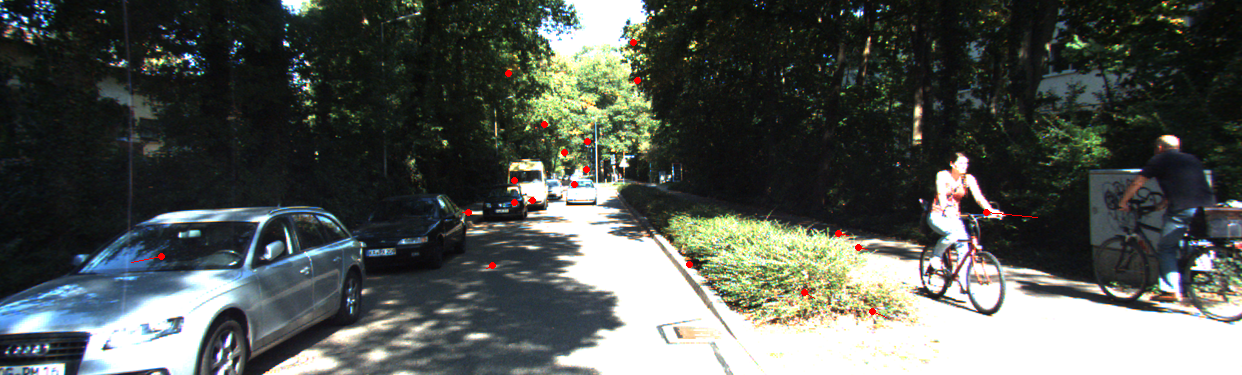

Essential Matrix: [[-1.16677906e-03 -7.06989637e-01 -1.15131318e-02]
 [ 7.06983658e-01 -1.19730880e-03  6.57522594e-03]
 [ 1.10256968e-02 -4.92257570e-03  2.27600923e-05]]
Residuals for corresponding points:
[6.08286241e-04 4.10227795e-04 2.54947663e-04 1.23577091e-03
 1.05331209e-03 5.72109592e-04 6.89399302e-04 3.24315670e-04
 1.40733197e-03 4.23498572e-04 5.48365008e-04 5.90944826e-04
 3.27941494e-04 3.28790791e-04 1.55210475e-04 6.15356348e-04
 7.55256901e-04 1.56387068e-04 1.93945006e-06 6.75265655e-04]
Residuals for random points:
[0.0175878  0.02582378 0.09346372 0.06965325 0.0251072  0.18160903
 0.04106192 0.14415212 0.09402217 0.06990366 0.04941262 0.16501419
 0.08981444 0.03180938 0.04249266 0.04658014 0.0910592  0.01069392
 0.00353687 0.00112614]


In [8]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

# Ground truth corresponding Keypoints in img_tn1 and img_t
kps_tn1 = np.array([[838,233],[508,73],[514,180],[468,212],[587,141],[492,265],[986,212],[633, 42],[872,311],[544,124],
                    [804,292],[858,247],[689,264],[161,256],[574,184],[637,80],[532,200],[514,202],[564,152],[586,169]])

kps_t = np.array([[ 848,235],[506,72],[512,180],[462,212],[587,141],[486,268],[1037,217],[632,39],[886,317],[542,124],
                  [814,298],[867,249],[690,267],[131,262],[572,184],[636,79],[528,200],[512,202],[564,152],[585,169]])
kps_tn1_ = np.column_stack((kps_tn1, np.ones(len(kps_tn1)))) @ np.linalg.inv(kitti_cam_calib).T
kps_t_ = np.column_stack((kps_t, np.ones(len(kps_t)))) @ np.linalg.inv(kitti_cam_calib).T

disp(img_tn1, kps_tn1, kps_t)

E = EssentialMatrixTransform()
E.estimate(kps_tn1_, kps_t_)

print(f"Essential Matrix: {E.params}")

print("Residuals for corresponding points:")
print(E.residuals(kps_tn1_, kps_t_))

print("Residuals for random points:")
permutation = np.random.choice(range(20), replace=False, size=20)
print(E.residuals(kps_tn1_, kps_t_[permutation]))

# Features utils

In [9]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=5000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance <= 1 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Main

#kps_tn2: 324 #kps_tn1: 266 #kps_t: 244
#matches_tn2_tn1: 102
#matches_tn1_t: 103
#matches_tn2_tn1_t: 49


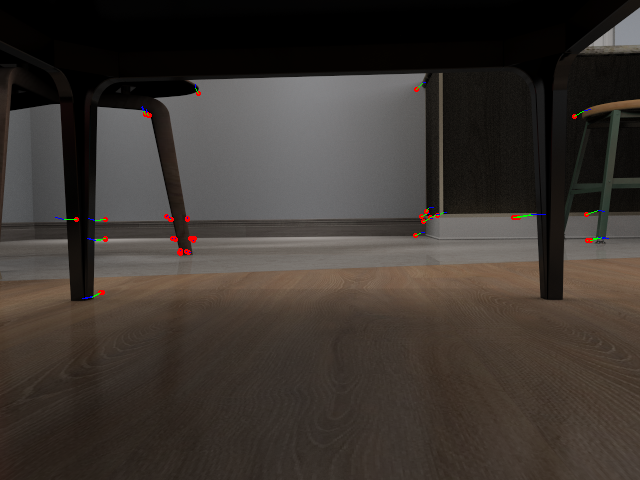

In [132]:
# img_tn2 = kitti_imgs[0]
# img_tn1 = kitti_imgs[1]
# img_t = kitti_imgs[2]
# K = kitti_cam_calib

img_tn2 = deer_robot_imgs[0]
img_tn1 = deer_robot_imgs[10]
img_t = deer_robot_imgs[15]
K = deer_robot_cam_calib

kps_tn2, des_tn2 = extract_features(img_tn2)
kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn2: {len(kps_tn2)} #kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

# From Image coordinate to Normalized homogeneous coordinate.
normalize = lambda kps: np.column_stack((kps, np.ones(len(kps)))) @ np.linalg.inv(K).T
kps_tn2_ = normalize(kps_tn2)
kps_tn1_ = normalize(kps_tn1)
kps_t_ = normalize(kps_t)

matches_tn2_tn1 = match_features2(des_tn2, des_tn1)
matches_tn1_t = match_features2(des_tn1, des_t)

E_tn2_tn1, inliers_tn2_tn1 = ransac(
  (kps_tn2_[matches_tn2_tn1[:,0]], kps_tn1_[matches_tn2_tn1[:,1]]),
  EssentialMatrixTransform,
  min_samples=8,
  residual_threshold=1e-3,
  max_trials=100
)
matches_tn2_tn1 = matches_tn2_tn1[inliers_tn2_tn1]

E_tn1_t, inliers_tn1_t = ransac(
  (kps_tn1_[matches_tn1_t[:,0]], kps_t_[matches_tn1_t[:,1]]),
  EssentialMatrixTransform,
  min_samples=8,
  residual_threshold=1e-3,
  max_trials=100
)
matches_tn1_t = matches_tn1_t[inliers_tn1_t]

print(f"#matches_tn2_tn1: {len(matches_tn2_tn1)}")
print(f"#matches_tn1_t: {len(matches_tn1_t)}")

matches_tn2_tn1_t = []
for i, kp in enumerate(matches_tn2_tn1[:,1]):
  j, = np.where(matches_tn1_t[:,0] == np.array(kp))
  assert len(j) in [0,1]
  if len(j) == 1:
    j = j[0]
    assert matches_tn2_tn1[i,1] == matches_tn1_t[j,0]
    matches_tn2_tn1_t.append([matches_tn2_tn1[i,0], matches_tn2_tn1[i,1], matches_tn1_t[j,1]])

matches_tn2_tn1_t = np.array(matches_tn2_tn1_t)
print(f"#matches_tn2_tn1_t: {len(matches_tn2_tn1_t)}")

disp2(
  img_tn1,
  kps_tn2[matches_tn2_tn1_t[:,0]],
  kps_tn1[matches_tn2_tn1_t[:,1]],
  kps_t[matches_tn2_tn1_t[:,2]]
)

E_tn2_tn1
E_tn1_t

R_tn2_tn1, t_tn2_tn1 = essential_to_Rt(
  E_tn2_tn1.params,
  kps_tn2_[matches_tn2_tn1_t[0,0]],
  kps_tn1_[matches_tn2_tn1_t[0,1]]
)

R_tn1_t, t_tn1_t = essential_to_Rt(
  E_tn1_t.params,
  kps_tn1_[matches_tn2_tn1_t[0,1]],
  kps_t_[matches_tn2_tn1_t[0,2]]
)

In [129]:
indices = np.random.choice(np.arange(len(matches_tn2_tn1_t)), 10, replace=False).reshape(5,2)

r = []
for i, j in indices:
  x_i_tn2 = triangulate(
    kps_tn2_[matches_tn2_tn1_t[i,0]],
    kps_tn1_[matches_tn2_tn1_t[i,1]],
    R_tn2_tn1,
    t_tn2_tn1
  )
  x_j_tn2 = triangulate(
    kps_tn2_[matches_tn2_tn1_t[j,0]],
    kps_tn1_[matches_tn2_tn1_t[j,1]],
    R_tn2_tn1,
    t_tn2_tn1
  )

  x_i_tn1 = triangulate(
    kps_tn1_[matches_tn2_tn1_t[i,1]],
    kps_t_[matches_tn2_tn1_t[i,2]],
    R_tn1_t,
    t_tn1_t
  )
  x_j_tn1 = triangulate(
    kps_tn1_[matches_tn2_tn1_t[j,1]],
    kps_t_[matches_tn2_tn1_t[j,2]],
    R_tn1_t,
    t_tn1_t
  )
  r.append(
    np.linalg.norm(x_i_tn2 - x_j_tn2) / np.linalg.norm(x_i_tn1 - x_j_tn1)
  )
  print(
    np.linalg.norm(kps_tn2[matches_tn2_tn1_t[i,0]]-kps_tn2[matches_tn2_tn1_t[j,0]]),
    r[-1]
  )
# r = np.array(r)

# print(r)
# print(np.mean(r))
# print(np.median(r))


536.6563145999495 0.3401187380054661
254.503438090726 1.0744709425673207
477.0010482168776 0.37186743630117947
157.16551784663199 1.1323508584677002
285.68689154387187 4.476915202686185


#kps_tn1: 327 #kps_t: 320
Before RANSAC
#matches: 242


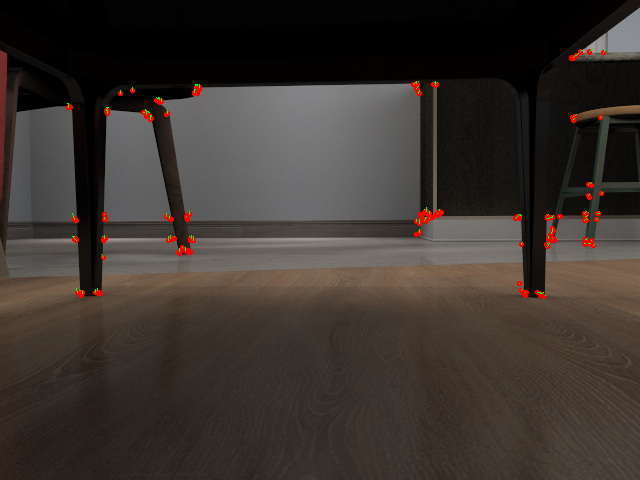

After RANSAC
#matches: 144


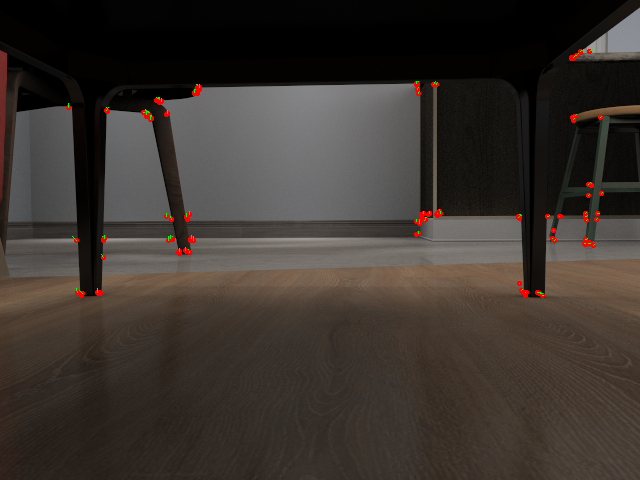

[[ 0.99997512  0.00694643  0.00122635]
 [-0.00695119  0.99996816  0.00391986]
 [-0.00119908 -0.00392828  0.99999157]]
[ 0.06387539 -0.02726378  0.9975854 ]


In [130]:
# img_tn2 = kitti_imgs[0]
# img_tn1 = kitti_imgs[1]
# img_t = kitti_imgs[2]
# K = kitti_cam_calib

img_tn2 = deer_robot_imgs[0]
img_tn1 = deer_robot_imgs[1]
img_t = deer_robot_imgs[2]
K = deer_robot_cam_calib

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

# From Image coordinate to Normalized homogeneous coordinate.
normalize = lambda kps: np.column_stack((kps, np.ones(len(kps)))) @ np.linalg.inv(K).T
kps_tn1_ = normalize(kps_tn1)
kps_t_ = normalize(kps_t)

print("Before RANSAC")
matches = match_features2(des_tn1, des_t)
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

print("After RANSAC")
E, inliers = ransac(
  (kps_tn1_[matches[:,0]], kps_t_[matches[:,1]]),
  EssentialMatrixTransform,
  min_samples=8,
  residual_threshold=1e-3,
  max_trials=100
)
matches = matches[inliers]

print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

np.set_printoptions(suppress=True)
R, t = essential_to_Rt(E.params, kps_tn1_[matches[0,0]], kps_t_[matches[0,1]])
print(R)
print(t)